# TSSL Lab 2 - Structural model, Kalman filtering and EM
We will continue to work with the Global Mean Sea Level (GMSL) data that we got acquainted with in lab 1. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

In this lab we will analyse this data using a structural time series model. We will first set up a model and implement a Kalman filter to infer the latet states of the model, as well doing long-term prediction. We will then implement a disturbance smoother and an expectation maximization algorithm to tune the parameters of the model. 

We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots

## 2.1 Setting up a structural state space model

We start by loading and plotting data to reming ourselves what it looks like.

In [2]:
data=pandas.read_csv('sealevel.csv',header=0)

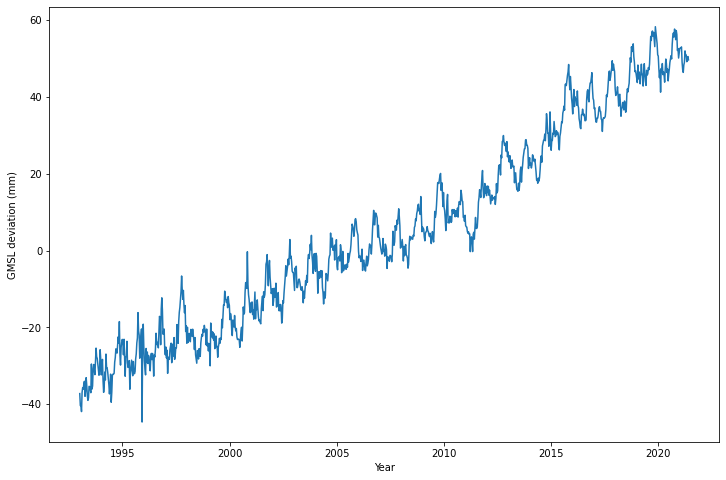

In [3]:
y = data['GMSL'].values
u = data['Year'].values
ndata = len(y)
plt.plot(u,y)
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

In this lab we will use a structural time series model to analys this data set. Specifically, we assume that the data $\{y_t\}_{t\geq 1}$ is generated by

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

where $\mu_t$ is a trend component, $\gamma_t$ is a seasonal component, and $\varepsilon_t$ is an observation noise. The model is expressed using a state space representation,

\begin{align}
    \alpha_{t+1} &= T \alpha_t + R\eta_t, & \eta_t&\sim N(0,Q), \\
    y_t &= Z \alpha_t + \varepsilon_t, & \varepsilon_t&\sim N(0,\sigma_\varepsilon^2).
\end{align}

**Q0:** Let $d = \dim(\alpha_t)$ denote the _state dimension_ and $d_\eta = \dim(\eta_t)$ denote the dimension of the state noise. Then, what are the dimenisons of the matrices $T$, $R$, and $Z$ of the state space model?

**A:** 

$dim(T) = (d,d)$ | 
$dim(R) = (d,2)$ | 
$dim(Z) = (1,d)$

**Q1:** Create the state space matrices $T_{[\mu]}$, $R_{[\mu]}$, and $Z_{[\mu]}$ corresponding to the trend component $\mu_t$. We assume a local linear trend (that is, of order $k=2$). 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [4]:
T_mu = np.ndarray((2,2), buffer=np.array([2, -1, 1, 0]), dtype=int)
R_mu = np.ndarray((2,1), buffer=np.array([1, 0]), dtype=int)
Z_mu = np.ndarray((1,2), buffer=np.array([1, 0]), dtype=int)

**Q2:** There is a yearly seasonal pattern present in the data. What should we set the periodicity $s$ of the seasonal component to, to capture this pattern?

_Hint:_ Count the average number of observations per (whole) year and round to the closest integer.

In [5]:
obs_per_year = data["Year"].round().value_counts()
s = round(obs_per_year.mean())

print(f"The average number of observations per year is: {s}")

The average number of observations per year is: 36


**Q3:** What is the _state dimension_ of a seasonal component with periodicity $s$? That is, how many states are needed in the corresponding state space representation?

**A:** The state dimension of a seasonal component is given by $s-1$. In our case we will get a state dimension value of 35.


**Q4:** Create the state space matrices $T_{[\gamma]}$, $R_{[\gamma]}$, and $Z_{[\gamma]}$ corresponding to the seasonal component $\gamma_t$. 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [6]:
T_gamma = np.ndarray((s,s), buffer=np.zeros(s*s))
T_gamma[0] = -np.ones(s)
T_gamma[1:,0:s-1] = np.identity(s-1)
R_gamma = np.ndarray((s,1), buffer=np.concatenate([np.array([1]), np.zeros(s-1)]))
Z_gamma = np.ndarray((1,s), buffer=np.concatenate([np.array([1]), np.zeros(s-1)]))

**Q5:** Using the matrices that you have constructed above, create the state space matrices for the complete structural time series model. Print out the shapes of the resulting system matrices and check that they correspond to what you expect (cf **Q0**).

_Hint:_ Use `scipy.linalg.block_diag` and `numpy.concatenate`.

In [7]:
from scipy.linalg import block_diag

In [8]:
T = block_diag(T_mu, T_gamma)
R = block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis=1)

In [9]:
print(f"Shape T: {np.shape(T)}\nShape R: {np.shape(R)}\nShape Z: {np.shape(Z)}")

Shape T: (38, 38)
Shape R: (38, 2)
Shape Z: (1, 38)


We also need to specify the variances of the process noise $\eta_t$ and measurement noise $\varepsilon_t$. Below, we will estimate (two of) these variances from data, but for now we set them arbitrarily to get an initial model to work with.

In [10]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

Finally, to complete the model we need to specify the distribution of the initial state. This encodes our _a priori_ belief about the actual values of the trend and seasonality, i.e., before observing any data.

**Q6:** Set up the mean vector of the initial state $a_1 = \mathbb{E}[\alpha_1]$ such that:
* The trend component starts at the first observation, $\mathbb{E}[\mu_1] = y_1$,
* The slope of the trend is _a priori_ zero in expectation, $\mathbb{E}[\mu_1 - \mu_0] = 0$,
* The initial mean of all states related to the seasonal component are zero.

Also, create an initial state covariance matrix $P_1 = \text{Cov}(\alpha_1)$ as an identity matrix of the correct dimension, multiplied with a large value (say, 100) to represent our uncertainty about the initial state.

In [11]:
a1 = np.ndarray((38,1), buffer=np.zeros(38))
a1[0] = y[0]
a1[1] = y[0]
P1 = np.identity(38) * 100

We have now defined all the matrices etc. that make up the structural state space model. For convenience, we can create an object of the class `LGSS` available in the module `tssltools_lab2` as a container for these quantities.

In [12]:
from tssltools_lab2 import LGSS
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

help(model.get_params)

Help on method get_params in module tssltools_lab2:

get_params() method of tssltools_lab2.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



## 2.2 Kalman filtering for the structural model
Now we have the data and a model available. Next, we will turn our attention to the inference problem, which is a central task when analysing time series data using the state space framework.

State inference is the problem of estimating the unknown (latent) state variables given the data. For the time being we assume that the _model parameters_ are completely specified, according to above, and only consider how to estimate the states using the Kalman filter.

In the questions below we will treat the first $n=800$ time steps as training data and the remaining $m$ observations as validation data. 

In [13]:
n = 800
m = ndata-n


**Q7:** Complete the Kalman filter implementation below. The function should be able to handle missing observations, which are encoded as "not a number", i.e. `y[t] = np.nan` for certain time steps `t`. 

_Hint:_ The Kalman filter involves a lot of matrix-matrix and matrix-vector multiplications. It turns out to be convient to store sequences of vectors (such as the predicted and filtered state estimates) as `(d,1,n)` arrays, instead of `(d,n)` or `(n,d)` arrays. In this way the matrix multiplications will result in 2d-arrays of the correct shapes without having to use a lot of explicit `reshape`. However, clearly, this is just a matter of coding style preferences!

In [14]:
from tssltools_lab2 import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    # Reference: Lecture 5 Slide 15 
    for t in range(n):
        # Time update (predict)
        # ADD CODE HERE
        # At time t=1 (in our case t=0) we initialize alpha and P using alpha_1 and P_1
        if t == 0:
            alpha_pred[:,:,t] = a1
            P_pred[:,:,t] = P1
        else:
            alpha_pred[:,0,t] = np.matmul(T, alpha_filt[:,0,t-1])
            TP = np.matmul(T, P_filt[:,:,t-1])
            TPT = np.matmul(TP, np.transpose(T))
            RQR = np.matmul(np.matmul(R, Q), np.transpose(R))
            P_pred[:,:,t] = TPT + RQR
            
        # Compute prediction of current output
        # ADD CODE HERE
        y_pred[t] = np.matmul(Z, alpha_pred[:,0,t])
        F_pred[t] = np.matmul(np.matmul(Z, P_pred[:,:,t]), np.transpose(Z)) + H # H=sigma_eps**2
        
        # Measurement update (correct)
        # ADD CODE HERE
        # If y_t is missing we skip the update and set alpha_t = alpha_t|t-1 and P_t = P_t|t-1
        if np.isnan(y[t]):
            alpha_filt[:,:,t] = alpha_pred[:,:,t]
            P_filt[:,:,t] = P_pred[:,:,t]
        else:
            K_t = np.matmul(P_pred[:,:,t], np.transpose(Z)) / F_pred[t] # Divide to get Inverse of F_pred
            alpha_filt[:,:,t] = alpha_pred[:,:,t] + np.dot(K_t, (y[t] - y_pred[t]))
            P_filt[:,:,t] = np.matmul((np.identity(d) - np.matmul(K_t, Z)), P_pred[:,:,t])

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

**Q8:** Use the Kalman filter to infer the states of the structural time series applied to the sealevel data. Run the filter on the training data (i.e., first $n=800$ time steps), followed by a long-range prediction of $y_t$ for the remaining time points. 

Generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ It is enough to call the `kalman_filter` function once. Make use of the missing data functionality!

In [15]:
# Copying y to y_train, then setting validation data to nan
y_train = np.copy(y)
y_train[n:ndata] = np.nan

x_train = u[0:n]
x_valid = u[n:ndata]

In [16]:
kf = kalman_filter(y=y_train, model=model)

In [17]:
plus1std = kf.y_pred + np.sqrt(kf.F_pred) 
minus1std = kf.y_pred - np.sqrt(kf.F_pred) 

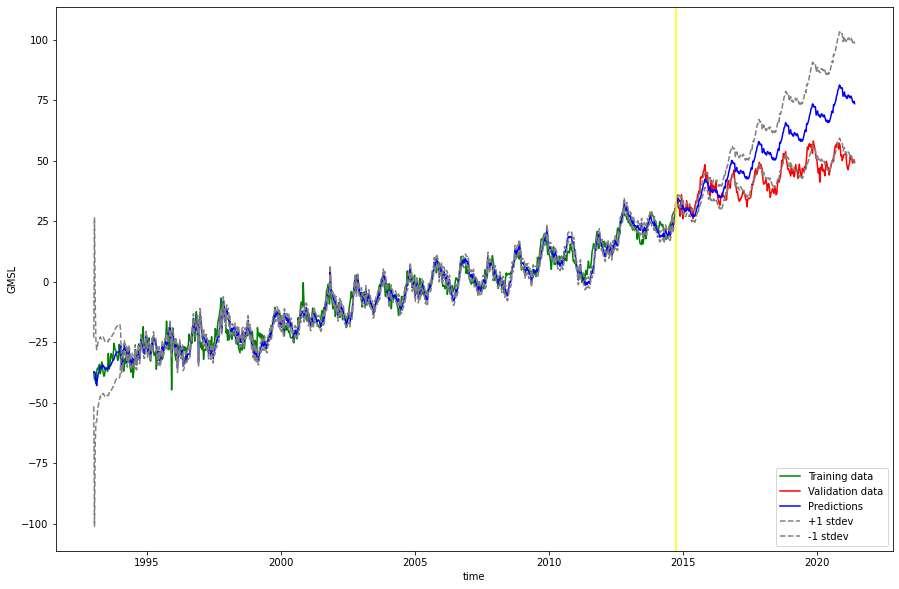

In [18]:
plt.figure(figsize=(15,10))
plt.plot(x_train, y[0:n], label='Training data', color="green")
plt.plot(x_valid, y[n:ndata], label='Validation data', color="red")
plt.plot(u, kf.y_pred, label="Predictions", color='blue')
plt.plot(u ,plus1std, label="+1 stdev", linestyle='--', color='grey')
plt.plot(u ,minus1std, label="-1 stdev", linestyle='--', color='grey')
plt.axvline(x=u[800], color="yellow")
plt.xlabel('time')
plt.ylabel('GMSL')
plt.legend(loc='lower right')
plt.show()

**Q9:** Based on the output of the Kalman filter, compute the training data log-likelihood $\log p(y_{1:n})$.

In [19]:
loglikelihood = -n/2* np.log(2*np.pi) - np.sum(np.log(kf.F_pred[0:n]) + (y_train[0:n]-kf.y_pred[0:n])**2/kf.F_pred[0:n])/2

print(f"Training data log-likelihood:", loglikelihood)

Training data log-likelihood: -2842.462622966206


## 2.3 Identifying the noise variances using the EM algorithm
So far we have used fixed model parameters when running the filter. In this section we will see how the model parameters can be learnt from data using the EM algorithm. Specifically, we will try to learn the variance of the state noise affecting the seasonal component as well as the variance of the observation noise,

\begin{align}
    \theta = (\sigma_\gamma^2, \sigma_\varepsilon^2).
\end{align}

For brevity, the variance of the trend component $\sigma_\mu^2$ is fixed to the value $\sigma_\mu^2 = 0.01^2$ as above. (See Appendix A below for an explanation.)

Recall that we consider $y_{1:n}$ as the training data, i.e., we will estimate $\theta$ using only the first $n=800$ observations.

**Q10:** Which optimization problem is it that the EM algorithm is designed to solve? Complete the line below!

**A:** $$\hat\theta = \arg\max_{\theta} \mathcal{Q}(\theta, \tilde \theta)$$

And we try to optimize the following expression (from lecture 6 slide 27):

$$
\begin{aligned}
\mathcal{Q}(\theta, \tilde \theta) &= const. \frac{-1}{2} \sum_{t=1}^{n}\bigg[ log(\sigma_{\epsilon}^2) + log|Q| + \frac{1}{\sigma_{\epsilon}^2} \{ \hat \epsilon_{t|n}^2 + Var[\epsilon_{t}|y_{1:n}]\} + tr\big[\{\hat \eta_{t|n}\hat \eta_{t|n}^T + Var[\eta_{t}|y_{1:n}]\} Q^{-1} \big]\bigg] 
\end{aligned}
$$

**Q11:** Write down the updating equations on closed form for the M-step in the EM algorithm.

_Hint: Look at Exercise Session 2_

**A:**

From the previous expression, we define Q such that:

$$
Q = \begin{pmatrix} \sigma_{\mu}^2 & 0\\ 0 & \sigma_{\eta}^2 \end{pmatrix}, \ \ \ \
Q^{-1} = \begin{pmatrix} \frac{1}{\sigma_{\mu}^2} & 0\\ 0 & \frac{1}{\sigma_{\eta}^2}  \end{pmatrix}, \ \ \ \ 
|Q| = \sigma_{\mu}^2\sigma_{\eta}^2
$$

We identify the term in the trace (that is not Q) as a 2x2 matrix with entries a, b, c and d at time t. Our trace term becomes:

$$
\begin{aligned}
tr\big[\{\hat \eta_{t|n}\hat \eta_{t|n}^T + var[\eta_{t}|y_{1:n}]\} Q^{-1} \big] &= \frac{a_t}{\sigma_{\mu}^2}\frac{d_t}{\sigma_{\eta}^2}
\end{aligned}
$$

If we now differentiate this with respect to $\sigma_{\eta}^2$ to obtain a closed form equation for our problem. We also do the same for the epsilon term that depends on $\sigma_{\epsilon}^2$ to obtain the following M step:

$$
\begin{aligned}
\sigma_{\eta}^2 &= \frac{1}{n} \sum_{t=1}^n d_t, \\
\sigma_{\epsilon}^2 &= \frac{1}{n} \sum_{t=1}^n \{ \hat \epsilon_{t|n}^2 + var[\epsilon_{t}|y_{1:n}]\}
\end{aligned}
$$


**reference: Time Series Analysis by State Space Methods: Second Edition (2012), J. Durbin & S.J. Koopman, Oxford University Press**

To implement the EM algorithm we need to solve a _smoothing problem_. The Kalman filter that we implemented above is based only on a forward propagation of information. The _smoother_ complements the forward filter with a backward pass to compute refined state estimates. Specifically, the smoothed state estimates comprise the mean and covariances of

\begin{align}
    &p(\alpha_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

Furthermore, when implementing the EM algorithm it is convenient to work with the (closely related) smoothed estimates of the disturbances, i.e., the state and measurement noise,

\begin{align}
    &p(\eta_t \mid y_{1:n}), & t=&1,\dots,n-1 \\
    &p(\varepsilon_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

An implementation of a state and disturbance smoother is available in the `tssltools_lab2` module. You may use this when implementing the EM algorithm below.


In [20]:
from tssltools_lab2 import kalman_smoother
# help(kalman_smoother)
ks = kalman_smoother(y=y, model=model, kf=kf)
eps_hat, eps_var, eta_hat, eta_cov =  ks.eps_hat, ks.eps_var, ks.eta_hat, ks.eta_cov

**Q12:** Implement an EM algorithm by completing the code below. Run the algorithm for 100 iterations and plot the traces of the parameter estimates, i.e., the values $\theta_r$, for $r = 0,\dots,100$.

_Note:_ When running the Kalman filter as part of the EM loop you should only filter the _training data_ (i.e. excluding the prediction for validation data).


In [21]:
# We define a log_likelihood function
def llik(y, kf):
#     n = np.count_nonzero(~np.isnan(y))
    llik = -n/2* np.log(2*np.pi) - np.sum(np.log(kf.F_pred[0:n]) + (y_train[0:n]-kf.y_pred[0:n])**2/kf.F_pred[0:n])/2
    return(llik)

In [24]:
num_iter = 100

# initalize values
theta_eps = np.array([],dtype=float)
theta_seas = np.array([],dtype=float)
llik_actual = 0
sigm_eps = sigma_eps

for r in range(1,num_iter):
    # E-step
    model = LGSS(T, R, Q, Z, sigm_eps**2, a1, P1)
    kalman_filt = kalman_filter(y=y_train,model=model)
    temp_llik = llik(y=y_train, kf=kalman_filt)
    
    #exit condition
    if np.abs(temp_llik - llik_actual) < 0.00001:
        break;
    else:
        llik_actual = temp_llik
    # M-step
    kalman_smooth = kalman_smoother(y=y_train, model=model,kf=kalman_filt)
    n = kalman_smooth.y_pred.shape[0]
    d = np.sum((kalman_smooth.eta_hat * kalman_smooth.eta_hat) + kalman_smooth.eta_cov, axis=2)
    sigma_sea = np.sqrt(d[1,1] / n)
    sigm_eps = np.sqrt(np.sum(kalman_smooth.eps_hat**2 + kalman_smooth.eps_var) / n)
    theta_eps = np.append(theta_eps, sigm_eps)
    theta_seas = np.append(theta_seas,sigma_sea)
    # Update Q
    Q = np.array([[sigma_trend**2, 0.], [0., sigma_sea**2]])
    
    

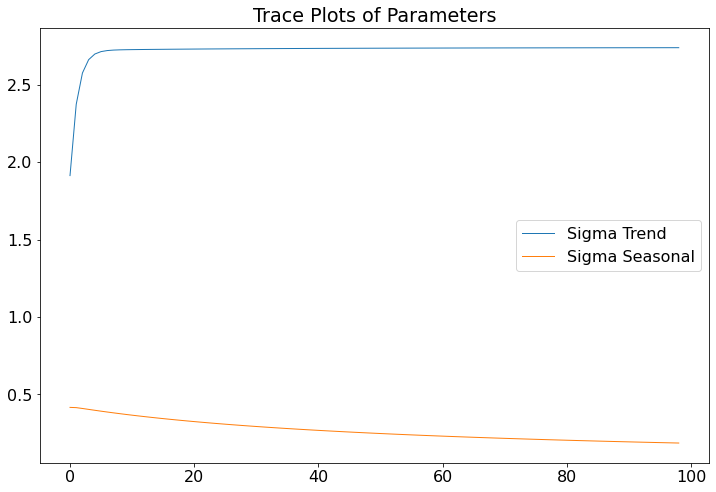

In [25]:
plt.rcParams.update({'font.size': 16})
plt.plot(theta_eps , label = "Sigma Trend",linewidth=1)
plt.plot(theta_seas, label = "Sigma Seasonal" ,linewidth=1)
plt.title('Trace Plots of Parameters')
plt.legend(loc='right')
plt.show()

## 2.4 Further analysing the data
We will now fix the model according to the final output from the EM algorithm and further analyse the data using this model.

**Q13:** Rerun the Kalman filter to compute a _long range prediction for the validation data points,_ analogously to **Q8** (you can copy-paste code from that question). That is, generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

Furthermore, compute the training data log-likelihood $\log p(y_{1:n})$ using the estimated model (cf. **Q9**).

In [40]:
kf = kalman_filter(y=y_train, model=model)
n=800

In [41]:
plus1std = kf.y_pred + np.sqrt(kf.F_pred) 
minus1std = kf.y_pred - np.sqrt(kf.F_pred) 

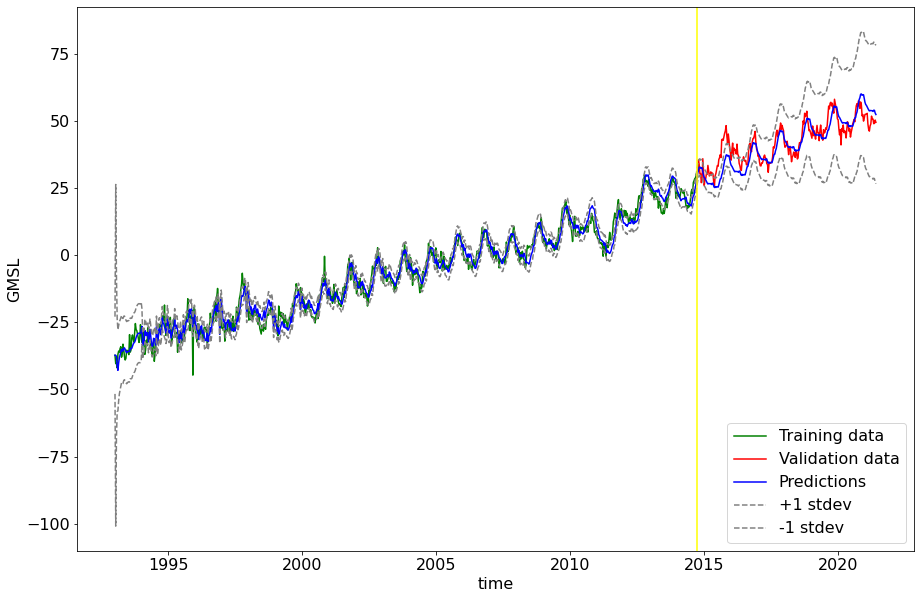

In [42]:
plt.figure(figsize=(15,10))
plt.plot(x_train, y[0:n], label='Training data', color="green")
plt.plot(x_valid, y[n:ndata], label='Validation data', color="red")
plt.plot(u, kf.y_pred, label="Predictions", color='blue')
plt.plot(u ,plus1std, label="+1 stdev", linestyle='--', color='grey')
plt.plot(u ,minus1std, label="-1 stdev", linestyle='--', color='grey')
plt.axvline(x=u[800], color="yellow")
plt.xlabel('time')
plt.ylabel('GMSL')
plt.legend(loc='lower right')
plt.show()

In [29]:
loglikelihood = -n/2* np.log(2*np.pi) - np.sum(np.log(kf.F_pred[0:n]) + (y_train[0:n]-kf.y_pred[0:n])**2/kf.F_pred[0:n])/2

print(f"Training data log-likelihood:", loglikelihood)

Training data log-likelihood: -2105.4417627565613


Note that we can view the model for the data $y_t$ as being comprised of an underlying "signal", $s_t = \mu_t + \gamma_t$ plus observation noise $\varepsilon_t$

\begin{align}
    y_t = s_t + \varepsilon_t
\end{align}

We can obtain refined, _smoothed,_ estimates of this signal by conditioning on all the training data $y_{1:n}$. 

**Q14:** Run a Kalman smoother to compute smoothed estimates of the signal, $\mathbb{E}[s_t | y_{1:n}]$, conditionally on all the _training data_. Then, similarly to above, plot the following:
1. The data $y_{1:n+m}$,
2. The smoothed estimates $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The predictions $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the validation data, i.e., $t = n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ Express $s_t$ in terms of $\alpha_t$. Based on this expression, compute the smoothed mean and variance of $s_t$ based on the smoothed mean and covariance of $\alpha_t$.

In [30]:
n = 800
ks = kalman_smoother(y=y_train, model=model,kf=kalman_filt)
s_t = np.zeros(len(y))
for t in range(len(y)):
    s_t[t] = np.matmul(Z, ks.alpha_pred[:,0,t])
ks_plus1std = s_t + np.sqrt(ks.F_pred) 
ks_minus1std = s_t - np.sqrt(ks.F_pred) 

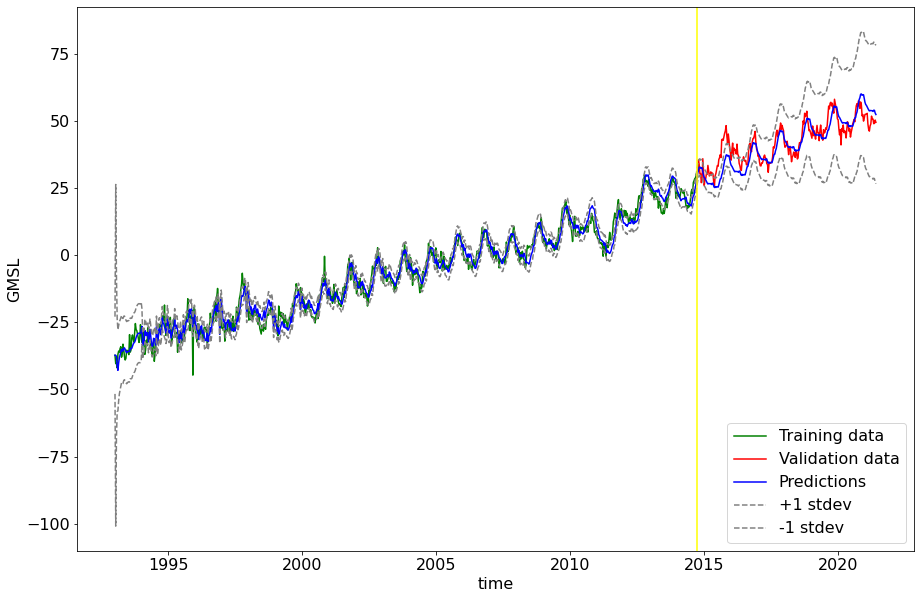

In [44]:
plt.figure(figsize=(15,10))
plt.plot(x_train, y[0:n], label='Training data', color="green")
plt.plot(x_valid, y[n:ndata], label='Validation data', color="red")
plt.plot(u, s_t, label="Predictions", color='blue')
plt.plot(u , ks_plus1std, label="+1 stdev", linestyle='--', color='grey')
plt.plot(u , ks_minus1std, label="-1 stdev", linestyle='--', color='grey')
plt.axvline(x=u[800], color="yellow")
plt.xlabel('time')
plt.ylabel('GMSL')
plt.legend(loc='lower right')
plt.show()

**Q15:** Explain, using a few sentences, the qualitative differences (or similarities) between the Kalman filter predictions plotted in **Q13** and the smoothed signal estimates plotted in **Q14** for,
1. Training data points, $t \leq n$
2. Validation data points, $t > n$

**A:** We see very little qualitative differences between the two plots. We expected to see notable differences between the two prediction lines on the validation data.

As stated in the lectures, we expected to see the smoother prediction to be less affected by the noise terms in the model as it uses all available data. On the other hand, the filter prediction should have showned more jagged features in the plot as it uses only data available until time t and is more affected by sudden changes in the direction of the data.

We can shed additional light on the properties of the process under study by further decomposing the signal into its trend and seasonal components.

**Q16:** Using the results of the state smoother, compute and plot the _smoothed estimates_ of the two signal components, i.e.:

1. Trend: $\hat \mu_{t|n} = \mathbb{E}[\mu_t | y_{1:n}]$ for $t = 1,\dots,n$
2. Seasonal: $\hat \gamma_{t|n} = \mathbb{E}[\gamma_t | y_{1:n}]$ for $t = 1,\dots,n$

_(You don't have to include confidence intervals here if don't want to, for brevity.)_

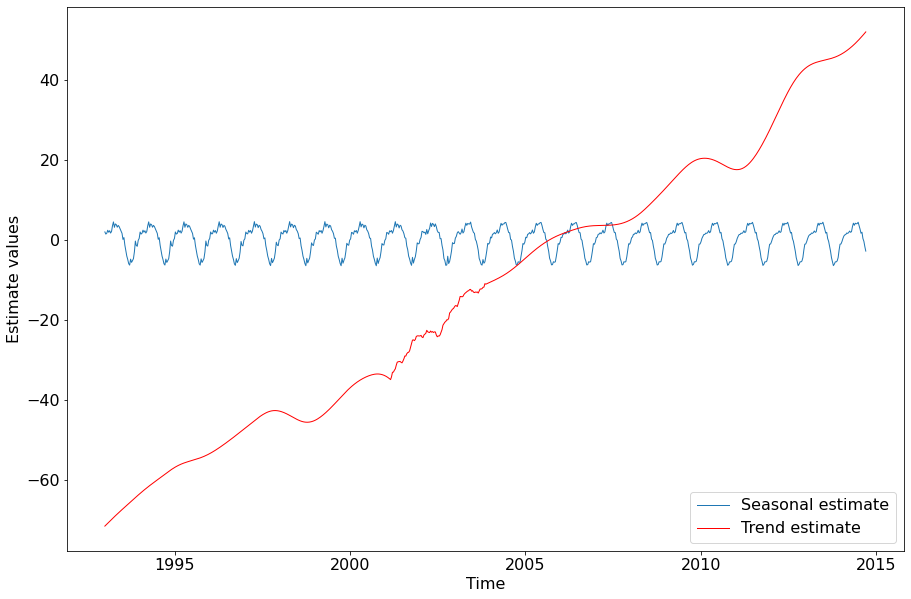

In [46]:
plt.figure(figsize=(15,10))
plt.plot(u[0:800], ks.alpha_sm[2:38,0,:].sum(axis=0)[0:800] , label = "Seasonal estimate",linewidth=1)
plt.plot(u[0:800], ks.alpha_sm[0:2,0,:].sum(axis=0)[0:800], label = "Trend estimate", c='red',linewidth=1)
plt.xlabel("Time")
plt.ylabel('Estimate values')
plt.legend(loc='lower right')
plt.show()

## 2.5 Missing data
We conclude this section by illustrating one of the key merits of the state space approach to time series analysis, namely the simplicity of handling missing data. To this end we will assume that a chunk of observations in the middle of the training data is missing.

**Q17:** Let the values $y_{t}$ for $ 300 < t \leq 400$ be missing. Modify the data and rerun the Kalman filter and smoother. Plot,
1. The Kalman filter predictions, analogously to **Q8**
2. The Kalman smoother predictions, analogously to **Q13**

Comment on the qualitative differences between the filter and smoother estimates and explain what you see (in a couple of sentences).

## Kalman Filter

In [33]:
y_train_miss = np.copy(y)
y_train_miss[300:400] = np.nan

In [34]:
kf_miss = kalman_filter(y=y_train_miss, model=model)

In [35]:
plus1std_miss = kf_miss.y_pred + np.sqrt(kf.F_pred) 
minus1std_miss = kf_miss.y_pred - np.sqrt(kf.F_pred) 

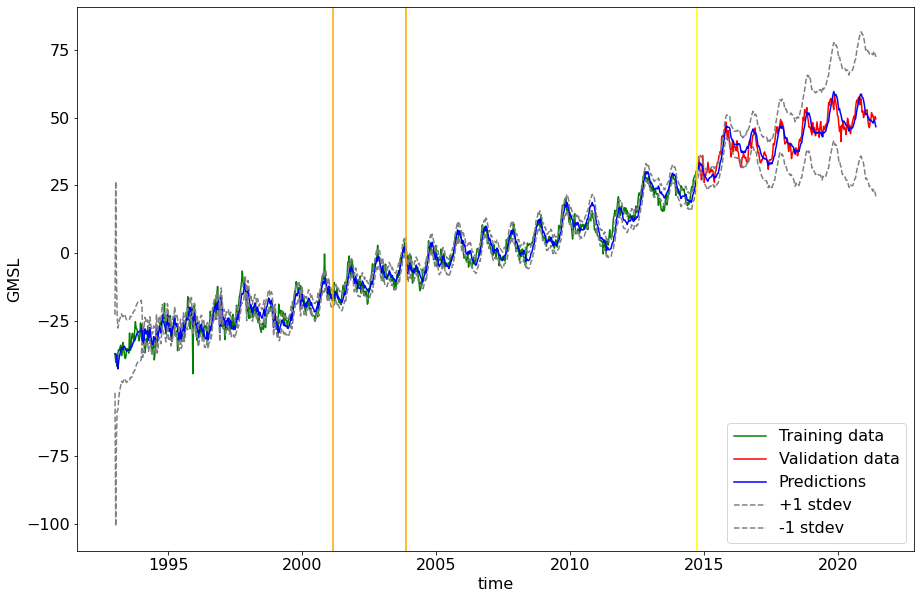

In [36]:
plt.figure(figsize=(15,10))
plt.plot(x_train, y[0:n], label='Training data', color="green")
plt.plot(x_valid, y[n:ndata], label='Validation data', color="red")
plt.plot(u, kf_miss.y_pred, label="Predictions", color='blue')
plt.plot(u ,plus1std_miss, label="+1 stdev", linestyle='--', color='grey')
plt.plot(u ,minus1std_miss, label="-1 stdev", linestyle='--', color='grey')
plt.axvline(x=u[800], color="yellow")
plt.axvline(x=u[300], color="orange")
plt.axvline(x=u[400], color="orange")
plt.xlabel('time')
plt.ylabel('GMSL')
plt.legend(loc='lower right')
plt.show()

## Kalman Smoother

In [37]:
ks_miss = kalman_smoother(y=y_train_miss, model=model,kf=kalman_filt)
n = 800
s_t_miss = np.zeros(len(y))
for t in range(len(y)):
    s_t_miss[t] = np.matmul(Z, ks_miss.alpha_sm[:,0,t])
    
ks_plus1std_miss = s_t_miss + np.sqrt(ks_miss.F_pred) 
ks_minus1std_miss = s_t_miss - np.sqrt(ks_miss.F_pred) 

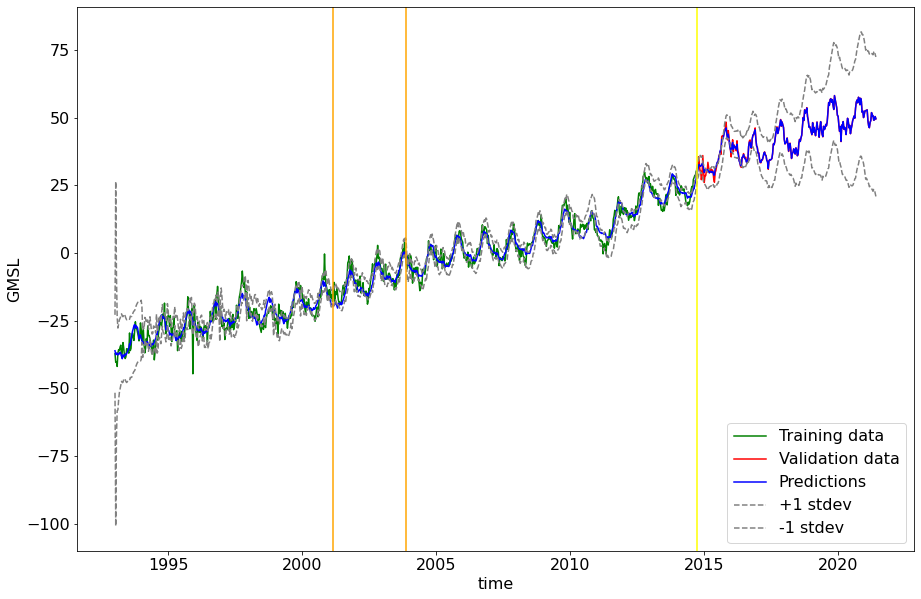

In [45]:
plt.figure(figsize=(15,10))
plt.plot(x_train, y[0:n], label='Training data', color="green")
plt.plot(x_valid, y[n:ndata], label='Validation data', color="red")
plt.plot(u, s_t_miss, label="Predictions", color='blue')
plt.plot(u ,plus1std_miss, label="+1 stdev", linestyle='--', color='grey')
plt.plot(u ,minus1std_miss, label="-1 stdev", linestyle='--', color='grey')
plt.axvline(x=u[800], color="yellow")
plt.axvline(x=u[300], color="orange")
plt.axvline(x=u[400], color="orange")
plt.xlabel('time')
plt.ylabel('GMSL')
plt.legend(loc='lower right')
plt.show()

**A:** Contrary to the previous exercise, we can clearly see differences between these plots. We observe here more clearly the difference that were stated earlier between the smoother and the filter predictions. Moreover, we notice that these effects are enhanced in the regions where data is "missing" (both in the middle of the sequence and on the validation data).

## Appendix A. Why didn't we learn the trend noise variance as well?
In the assignment above we have fixed $\sigma_\mu$ to a small value. Conceptually it would have been straightforward to learn also this parameter with the EM algorithm. However, unfortunately, the maximum likelihood estimate of $\sigma_\mu$ often ends up being too large to result in accurate _long term predictions_. The reason for this issue is that the structural model

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

is not a perfect description of reality. As a consequence, when learning the parameters the mismatch between the model and the data is compensated for by increasing the noise variances. This results in a trend component which does not only capture the long term trends of the data, but also seemingly random variations due to a model misspecification, possibly resulting in poor _long range predictions_.

Kitagawa (Introduction to Time Series Modeling, CRC Press, 2010, Section 12.3) discusses this issue and proposes two solutions. The first is a simple and pragmatic one: simply fix $\sigma_\mu^2$ to a value smaller than the maximum likelihood estimate. This is the approach we have taken in this assignment. The issue is of course that in practice it is hard to know what value to pick, which boild down to manual trial and error (or, if you are lucky, the designer of the lab assignment will tell you which value to use!).

The second, more principled, solution proposed by Kitagawa is to augment the model with a stationary AR component as well. That is, we model

\begin{align}
    y_t = \mu_t + \gamma_t + \nu_t + \varepsilon_t
\end{align}

where $\nu_t \sim$ AR$(p)$. By doing so, the stationary AR component can compensate for the discrepancies between the original structural model and the "true data generating process". It is straightforward to include this new component in the state space representation (how?) and to run the Kalman filter and smoother on the resulting model. Indeed, this is one of the beauties with working with the state space representation of time series data! However, the M-step of the EM algorithm becomes a bit more involved if we want to use the method to estimate also the AR coefficients of the $\nu$-component, which is beyond the scope of this lab assignment.